# Detecting Anomalies in Wafer Manufacturing

## Wafer fabrication is a procedure composed of many repeated sequential processes to produce complete electrical or photonic circuits on semiconductor wafers. Examples include production of radio frequency (RF) amplifiers, LEDs, optical computer components, and microprocessors for computers. Wafer fabrication is used to build components with the necessary electrical structures.

### About the dataset I have no information where they came from, I only know that I found them in kaggle.

### We import the necessary libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Merge train and test to apply feature engineering
- As test doesn't have a target column

In [2]:
df=pd.read_csv('Train.csv')
df_test=pd.read_csv('Test.csv')
df_pred=pd.DataFrame()
df_both=pd.concat([df,df_test], ignore_index=True)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100.0,160.0,1.6000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,20.0,83.0,4.1500,1.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0.0
2,99.0,150.0,1.5151,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,40.0,40.0,1.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,12.0,234.0,19.5000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2515,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2516,12.0,101.0,8.4166,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2517,31.0,88.0,2.8387,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [3]:
df.shape,df_test.shape,df_both.shape

((1763, 1559), (756, 1558), (2519, 1559))

In [4]:
df_both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Columns: 1559 entries, feature_1 to Class
dtypes: float64(5), int64(1554)
memory usage: 30.0 MB


### Outliers Resample

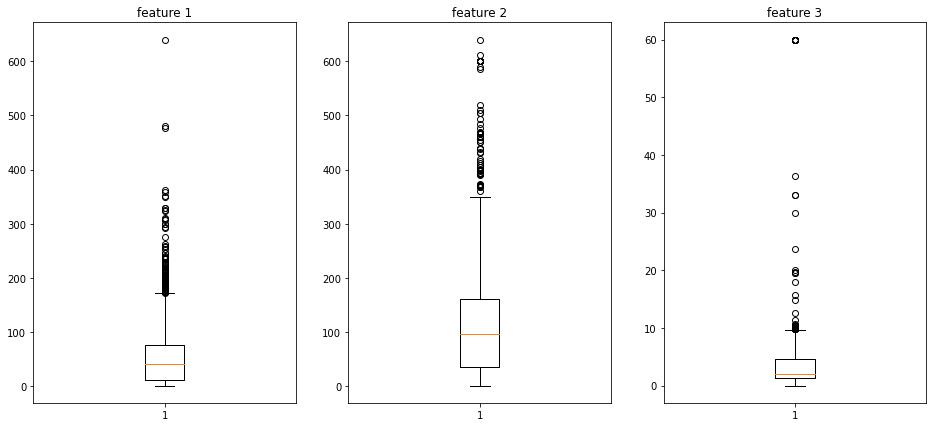

In [5]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df_both[f'feature_{i+1}'])

In [5]:
for col in df_both.columns[:3]:
    l=0.1 if col=='feature_2' else 0.05
    df_both[col]=winsorize(df_both[col],limits=l)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100.0,160.0,1.6000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,20.0,83.0,4.1500,1.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0.0
2,99.0,150.0,1.5151,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,40.0,40.0,1.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,12.0,234.0,8.4166,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2515,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2516,12.0,101.0,8.4166,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2517,31.0,88.0,2.8387,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


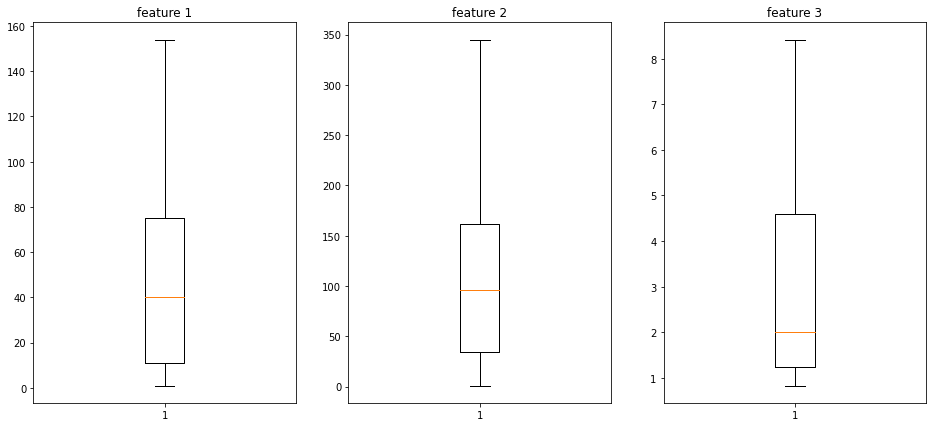

In [6]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df_both[f'feature_{i+1}'])

### Standard scale

#### Why scaling? if the values of the features are closer to each other there are chances for the algorithm to get trained well and faster instead of the data set where the data points or features values have high differences with each other will take more time to understand the data and the accuracy will be lower.

### The curious thing about feature scaling – it improves (significantly) the performance of some machine learning algorithms and does not work at all for others, so lets try to scale the first 3 columns of our dataframe

In [7]:
df2=pd.DataFrame(StandardScaler().fit_transform(df_both.iloc[:,:3]),columns=df_both.columns[:3])
df_both=pd.concat([df2,df_both.iloc[:,3:]],axis=1)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0.0
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2515,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2516,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2517,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


### We separate our data again

In [8]:
df=df_both[:df.shape[0]] #training data
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0.0
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.067521,-1.120720,-0.463653,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1759,-0.224012,0.806948,0.724871,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1760,0.987180,0.981310,-0.356369,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1761,-0.743094,-0.345778,0.749632,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [9]:
df_test=df_both[df.shape[0]+1:].iloc[:,:-1].reset_index(drop=True) #testing data
df_test

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,1.246721,0.603526,-0.599382,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.208557,2.211530,1.834160,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.208557,0.032006,-0.463653,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.614405,0.080440,-0.859827,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
751,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
753,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Now, we are going to check how our dataframe is balanced with the training data.

In [10]:
df.Class.value_counts()

0.0    1620
1.0     143
Name: Class, dtype: int64

#### we can see that there is no balance, since we have a lot of data from one label (0) and we have very little from another label (1)

### OverSampling

In [11]:
def train_test(x,y):
    ros=RandomOverSampler(random_state=0)
    ros.fit(x,y)
    x_res,y_res=ros.fit_resample(x,y)
    x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state = 1)
    return x_train,x_test,y_train,y_test

x=df.drop('Class',axis=1)
y=df.Class
x_train,x_test,y_train,y_test=train_test(x,y)

In [12]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2592, 1558), (648, 1558), (2592,), (648,))

## Now its time to apply models!

In [13]:
def apply_model(model,x_train,x_test,y_train,y_test):
    print(' '*20+re.search(r'(.*)\(',f'''{model}''',re.M).group(1))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('')
    print('Train Score:  ',model.score(x_train,y_train))
    print('Test Score:   ',model.score(x_test,y_test))
    print('')
    plot_confusion_matrix(model, x_test, y_test)
    print(classification_report(y_test,y_pred))

d={}
def predict_test(model):
    col=re.search(r'(.*)\(',f'''{model}''',re.M).group(1)
    if col not in d:
        d[col]=1
    else:
        d[col]+=1
    col+=f'{d[col]}'
    df_pred[col]=model.predict(df_test)
    df_pred

## We are going to apply 7 different models:

In [14]:
lr=LogisticRegression(solver='liblinear')    
svm=SVC(probability=True)
dt=DecisionTreeClassifier(max_depth=10,max_features=8,random_state=100)
rf=RandomForestClassifier(max_depth=4, max_features=3)
knn=KNeighborsClassifier(n_neighbors=94)
gnb=GaussianNB()
xgb=xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')

## Logistic Regression

#### Logistic regression is a technique widely used by data scientists due to its efficiency and simplicity. It is not necessary to have large computational resources, both in training and in execution.

#### It's ideal when your data can be perfectly classified using a simple division


                    LogisticRegression

Train Score:   0.9564043209876543
Test Score:    0.9367283950617284

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       328
         1.0       0.93      0.95      0.94       320

    accuracy                           0.94       648
   macro avg       0.94      0.94      0.94       648
weighted avg       0.94      0.94      0.94       648



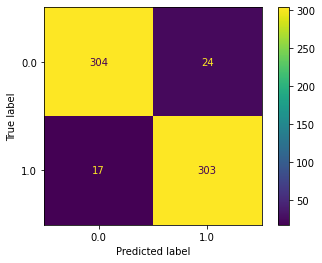

In [15]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

## Support Vector Machines (SVM)

#### One of the reasons related to using SVM is if you are in a space with many dimensions.

                    SVC

Train Score:   0.9567901234567902
Test Score:    0.9290123456790124

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       328
         1.0       0.92      0.94      0.93       320

    accuracy                           0.93       648
   macro avg       0.93      0.93      0.93       648
weighted avg       0.93      0.93      0.93       648



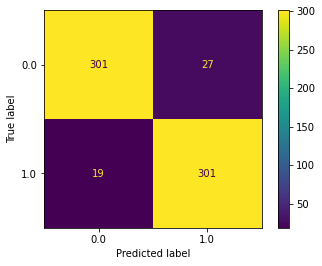

In [16]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

## KNeighborsClassifier

#### It is used essentially to classify values looking for the “most similar” data points (by proximity)

                    KNeighborsClassifier

Train Score:   0.8020833333333334
Test Score:    0.8148148148148148

              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83       328
         1.0       0.90      0.71      0.79       320

    accuracy                           0.81       648
   macro avg       0.83      0.81      0.81       648
weighted avg       0.83      0.81      0.81       648



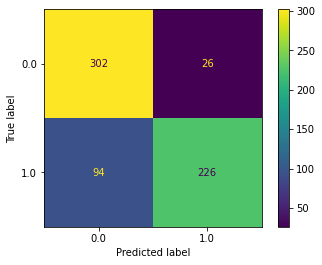

In [17]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

## GaussianNB

####  Naive Bayes is a generation method, that is, it directly finds the joint distribution P (X, Y) of the output of characteristic Y and characteristic X, and then uses P (Y | X) = P (X, Y) / P (X) inferred. Naive Bayes is very intuitive and does not require many calculations.

#### In GaussianNB the prior is the Gaussian distribution (Normal distribution)

                    GaussianNB

Train Score:   0.8935185185185185
Test Score:    0.8950617283950617

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       328
         1.0       0.82      1.00      0.90       320

    accuracy                           0.90       648
   macro avg       0.91      0.90      0.89       648
weighted avg       0.91      0.90      0.89       648



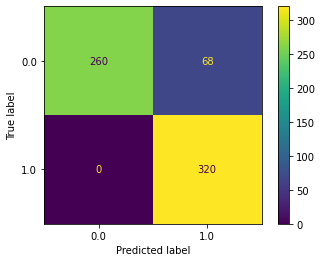

In [18]:
apply_model(gnb,x_train,x_test,y_train,y_test)
predict_test(gnb)

## DecisionTreeClassifier

#### In this technique, we divide the data into two or more homogeneous sets based on the most significant differentiator in the input variables.

#### Tree-based methods empower predictive models with high precision, stability, and ease of interpretation.

                    DecisionTreeClassifier

Train Score:   0.7735339506172839
Test Score:    0.7592592592592593

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       328
         1.0       0.90      0.58      0.70       320

    accuracy                           0.76       648
   macro avg       0.80      0.76      0.75       648
weighted avg       0.80      0.76      0.75       648



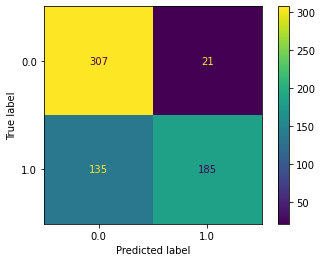

In [19]:
apply_model(dt,x_train,x_test,y_train,y_test) 
predict_test(dt)

## RandomForestClassifier

#### One of the most striking benefits of this technique is the power to handle large amounts of data with greater dimensionality. It can handle thousands of input variables and identify the most significant variables, which is why it is considered one of the dimensionality reduction methods.

                    RandomForestClassifier

Train Score:   0.8314043209876543
Test Score:    0.8040123456790124

              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83       328
         1.0       0.92      0.66      0.77       320

    accuracy                           0.80       648
   macro avg       0.83      0.80      0.80       648
weighted avg       0.83      0.80      0.80       648



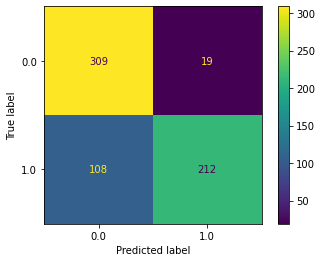

In [20]:
apply_model(rf,x_train,x_test,y_train,y_test) 
predict_test(rf)

##  XGBClassifier

#### XGBoost uses decision trees as base learners; combining many weak learners to make a strong learner. As a result it is referred to as an ensemble learning method since it uses the output of many models in the final prediction. 

                    XGBClassifier

Train Score:   0.9857253086419753
Test Score:    0.9552469135802469

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       328
         1.0       0.93      0.99      0.96       320

    accuracy                           0.96       648
   macro avg       0.96      0.96      0.96       648
weighted avg       0.96      0.96      0.96       648



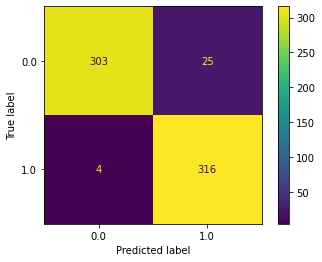

In [21]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

## Viewing the predictions of each model

In [22]:
df_pred

,LogisticRegression1,SVC1,KNeighborsClassifier1,GaussianNB1,DecisionTreeClassifier1,RandomForestClassifier1,XGBClassifier1
0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0
2,1.0,1.0,1.0,0.0,0.0,1.0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0
751,0.0,0.0,0.0,0.0,0.0,0.0,0
752,0.0,0.0,0.0,0.0,0.0,0.0,0
753,0.0,0.0,0.0,0.0,0.0,0.0,0


# We are going to solve again the same sequence but now with the implementation of t-SNE

### t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [23]:
ts=TSNE(learning_rate=50)
features=ts.fit_transform(df_both.drop('Class',axis=1))
tsne_x,tsne_y='tsne_x','tsne_y'
df_both[tsne_x]=features[:,0]
df_both[tsne_y]=features[:,1]
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class,tsne_x,tsne_y
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,19.663294,4.054934
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0.0,-9.436973,40.446011
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,23.179049,24.659346
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,-11.050445,0.537266
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,-19.469515,19.526424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,-23.394344,-6.519535
2515,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,40.228100,39.301979
2516,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,-48.578068,-28.132179
2517,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,-14.098639,-31.062279


In [24]:
df=df_both[:df.shape[0]]
df_test=df_both[df.shape[0]+1:].iloc[:,-2:].reset_index(drop=True)
df_test

,tsne_x,tsne_y
0,24.032734,-40.931190
1,-25.351572,-20.714134
2,-14.088897,31.458992
3,-7.281382,64.562614
4,17.060476,8.675390
...,...,...
750,-23.394344,-6.519535
751,40.228100,39.301979
752,-48.578068,-28.132179
753,-14.098639,-31.062279


In [25]:
x=df[[tsne_x,tsne_y]]
y=df[['Class']].values
x_train,x_test,y_train,y_test= train_test(x,y)

## Logistic Regression

                    LogisticRegression

Train Score:   0.7592592592592593
Test Score:    0.7577160493827161

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       328
         1.0       0.75      0.77      0.76       320

    accuracy                           0.76       648
   macro avg       0.76      0.76      0.76       648
weighted avg       0.76      0.76      0.76       648



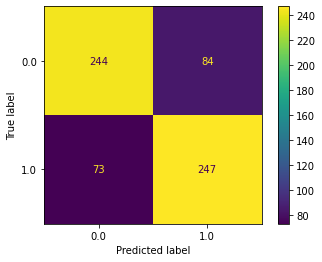

In [26]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

## Support Vector Machines (SVM)

                    SVC

Train Score:   0.8051697530864198
Test Score:    0.808641975308642

              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       328
         1.0       0.85      0.74      0.79       320

    accuracy                           0.81       648
   macro avg       0.81      0.81      0.81       648
weighted avg       0.81      0.81      0.81       648



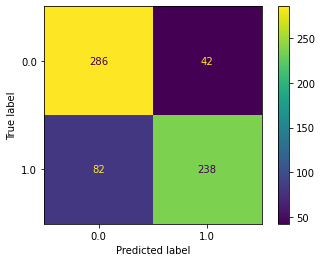

In [27]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

## KNeighborsClassifier

                    KNeighborsClassifier

Train Score:   0.7947530864197531
Test Score:    0.7808641975308642

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       328
         1.0       0.80      0.75      0.77       320

    accuracy                           0.78       648
   macro avg       0.78      0.78      0.78       648
weighted avg       0.78      0.78      0.78       648



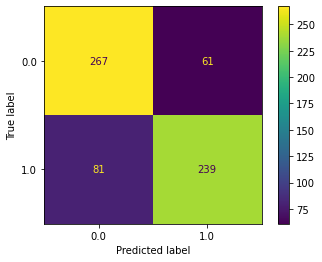

In [28]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

## GaussianNB

                    GaussianNB

Train Score:   0.7689043209876543
Test Score:    0.7716049382716049

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       328
         1.0       0.76      0.78      0.77       320

    accuracy                           0.77       648
   macro avg       0.77      0.77      0.77       648
weighted avg       0.77      0.77      0.77       648



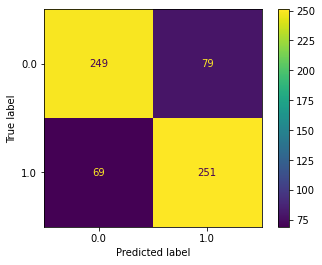

In [29]:
apply_model(gnb,x_train,x_test,y_train,y_test) 
predict_test(gnb)

##  XGBClassifier

                    XGBClassifier

Train Score:   0.9934413580246914
Test Score:    0.9629629629629629

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       328
         1.0       0.93      1.00      0.96       320

    accuracy                           0.96       648
   macro avg       0.97      0.96      0.96       648
weighted avg       0.97      0.96      0.96       648



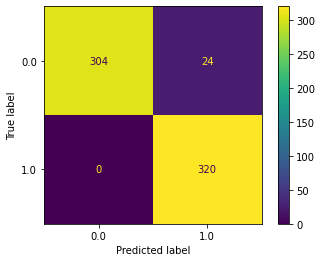

In [30]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

## k-means

#### K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The 'means' in the K-means refers to averaging of the data; that is, finding the centroid.

In [31]:
def kmeans_clus(df,not_x,not_y,k,cluster_label):
    df=df.copy()
    centroids,distortions=kmeans(df[[not_x,not_y]],k_or_guess=k)
    labels,_=vq(df[[not_x,not_y]],centroids)
    df[cluster_label]=labels
    sns.scatterplot(x=not_x,y=not_y,data=df,hue=cluster_label)
    for i in range(k):
        plt.scatter(x=centroids[i,0],y=centroids[i,1],s=500,cmap='Cyan')

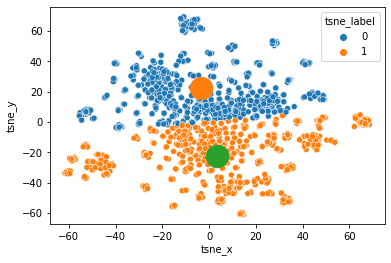

In [32]:
kmeans_clus(df,tsne_x,tsne_y,2,'tsne_label')

#### This is what our data looks like after applying t-sne to it

# We are going to solve again the same sequence but now with the implementation of PCA

#### The most important use of PCA is to represent a multivariate data table as smaller set of variables (summary indices) in order to observe trends, jumps, clusters and outliers. This overview may uncover the relationships between observations and variables, and among the variables.

In [33]:
pca=PCA(random_state=44)
pc=pca.fit_transform(df_both.drop('Class',axis=1))
len(pc[0])
pc_x,pc_y='pc_x','pc_y'
df_both[pc_x]=pc[:,0]
df_both[pc_y]=pc[:,1]

In [34]:
df=df_both[:df.shape[0]]
df_test=df_both[df.shape[0]+1:].iloc[:,-2:].reset_index(drop=True)

In [36]:
x=df[[pc_x,pc_y]]
y=df[['Class']].values
x_train,x_test,y_train,y_test=train_test(x,y)

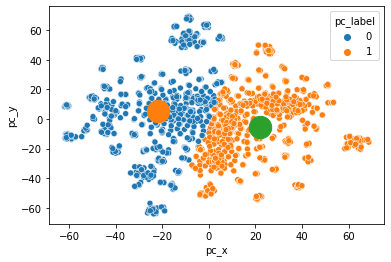

In [37]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

                    LogisticRegression

Train Score:   0.7592592592592593
Test Score:    0.7577160493827161

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       328
         1.0       0.75      0.77      0.76       320

    accuracy                           0.76       648
   macro avg       0.76      0.76      0.76       648
weighted avg       0.76      0.76      0.76       648



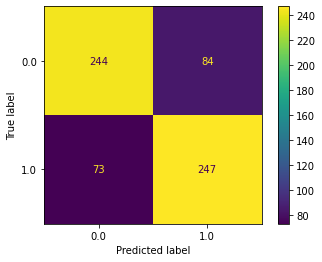

In [38]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

                    SVC

Train Score:   0.8059413580246914
Test Score:    0.8101851851851852

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82       328
         1.0       0.85      0.74      0.79       320

    accuracy                           0.81       648
   macro avg       0.82      0.81      0.81       648
weighted avg       0.81      0.81      0.81       648



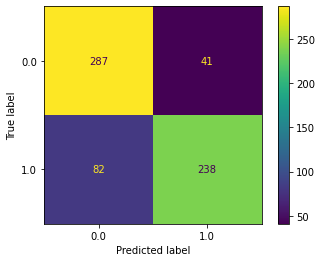

In [39]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

                    KNeighborsClassifier

Train Score:   0.7943672839506173
Test Score:    0.7777777777777778

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       328
         1.0       0.79      0.75      0.77       320

    accuracy                           0.78       648
   macro avg       0.78      0.78      0.78       648
weighted avg       0.78      0.78      0.78       648



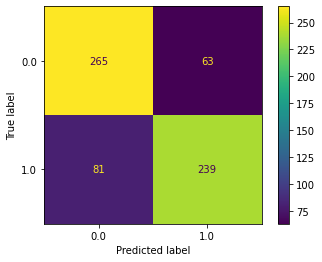

In [40]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

                    GaussianNB

Train Score:   0.7650462962962963
Test Score:    0.7638888888888888

              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76       328
         1.0       0.75      0.78      0.77       320

    accuracy                           0.76       648
   macro avg       0.76      0.76      0.76       648
weighted avg       0.76      0.76      0.76       648



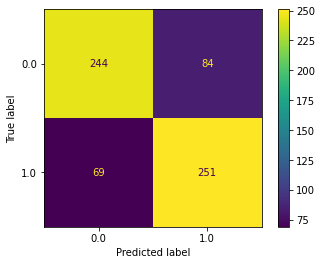

In [41]:
apply_model(gnb,x_train,x_test,y_train,y_test) 
predict_test(gnb)

                    XGBClassifier

Train Score:   0.9934413580246914
Test Score:    0.9598765432098766

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       328
         1.0       0.92      1.00      0.96       320

    accuracy                           0.96       648
   macro avg       0.96      0.96      0.96       648
weighted avg       0.96      0.96      0.96       648



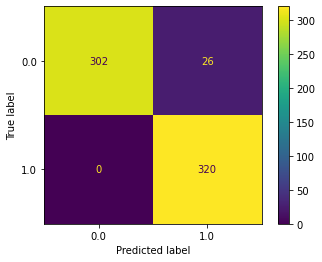

In [42]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

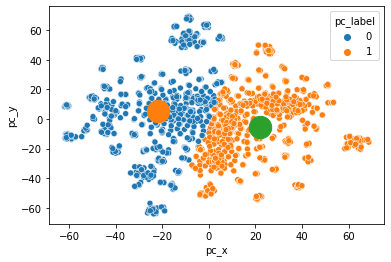

In [43]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

### Final Predictions For Test

In [44]:
df_pred

,LogisticRegression1,SVC1,KNeighborsClassifier1,GaussianNB1,DecisionTreeClassifier1,RandomForestClassifier1,XGBClassifier1,LogisticRegression2,SVC2,KNeighborsClassifier2,GaussianNB2,XGBClassifier2,LogisticRegression3,SVC3,KNeighborsClassifier3,GaussianNB3,XGBClassifier3
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0
2,1.0,1.0,1.0,0.0,0.0,1.0,0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
751,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
752,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
753,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0


In [45]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class,tsne_x,tsne_y,pc_x,pc_y
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,19.663294,4.054934,-3.175085,-20.173354
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,...,0,1,0,0,0,0.0,-9.436973,40.446011,41.327027,-6.327772
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,23.179049,24.659346,14.705481,-30.967286
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,-11.050445,0.537266,4.749547,9.718582
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,-19.469515,19.526424,25.577860,10.669035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.067521,-1.120720,-0.463653,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,-18.281214,-16.401175,-8.365419,22.667948
1759,-0.224012,0.806948,0.724871,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.261865,44.943169,41.980269,-17.010909
1760,0.987180,0.981310,-0.356369,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,14.665501,14.316611,8.215478,-19.264992
1761,-0.743094,-0.345778,0.749632,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0.0,-38.471577,-3.361325,11.183861,36.695031
